In [1]:
#Intial set-up, global vars intitalized and LIGO skymap read in
import healpy as hp
import numpy as np
from astropy.cosmology import FlatLambdaCDM,z_at_value
import astropy.units as u
import matplotlib.pyplot as plt
import posterior_utils as pos

skymap_name='/global/homes/w/wballard/catalogs/GW190412_skymap.fits.gz'
#skymap_name='/global/homes/w/wballard/standard-sirens/GW190412_C01_SEOBNRv4PHM.fits'
print(skymap_name)
H0_min=20
H0_max=140
Omega_m=0.3
z_min=0.001
z_max=0.5
nh0bins = 100
extinction_coeff=2.165 #from legacy survey

pb,distmu,distsigma,distnorm=hp.read_map(skymap_name,field=range(4),memmap=True)
NSIDE=hp.npix2nside(len(pb))
pixarea=hp.nside2pixarea(NSIDE)
pixarea_deg=hp.nside2pixarea(NSIDE,degrees=True)
pb_frac=0.90

/global/homes/w/wballard/catalogs/GW190412_skymap.fits.gz


In [2]:
#Read in galaxy catalog
from astropy.io import fits
ra_column_name='TARGET_RA'
dec_column_name='TARGET_DEC'
z_column_name='Z'
zerr_column_name='ZERR'
flux_column_name='FLUX_R'
pix_column_name='hpix1024'
ebv_column_name='EBV'
target_column_name='TARGETID'
glx_catalog_name="/global/homes/w/wballard/standard-sirens/reducedCatalogBGS.fits"

h=fits.open(glx_catalog_name,memmap=True)[1].data
flux_g=h[flux_column_name]
z_g=h[z_column_name]
ra_g=h[ra_column_name]
dec_g=h[dec_column_name]
zerr_g=h[zerr_column_name]
pix_g=h[pix_column_name]
ebv_g=h[ebv_column_name]
targets_g=h[target_column_name]
print(len(ra_g))



6541993


In [3]:
#Adjust flux for extinction and then apply absolute magnitude cut
transmission_mw=ebv_g*extinction_coeff
corrected_flux=flux_g/transmission_mw
omag_g=22.5-2.5*np.log10(corrected_flux) #from legacy survey webpage
abs_mag=omag_g-pos.dist_mod(z_g)
abs_mag_cut=abs_mag<-21.5
flux=flux_g[abs_mag_cut]
z=z_g[abs_mag_cut]
ra=ra_g[abs_mag_cut]
dec=dec_g[abs_mag_cut]
zerr=zerr_g[abs_mag_cut]
pix=pix_g[abs_mag_cut]
targets=targets_g[abs_mag_cut]
print(len(ra))

5479226


In [4]:
#Get pixels with prob less than pb_frac
i = np.flipud(np.argsort(pb))
sorted_credible_levels = np.cumsum(pb[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels
mask=(credible_levels<=pb_frac)
cred_cut=credible_levels[mask]

roi_area=np.sum(mask) * hp.nside2pixarea(NSIDE, degrees=True)

ramax,decmax=hp.pix2ang(NSIDE,np.argmax(pb),lonlat=True)

distmu_avg=np.average(distmu[mask],weights=pb[mask])
distsig_avg=np.average(distsigma[mask],weights=pb[mask])
print(distmu_avg)
print(distsig_avg)
print(roi_area)



722.3120071004954
74.63887006430915
11.891086137425399


In [5]:
#Cut based on z_min and z_max for given cosmologies
cosmomin=FlatLambdaCDM(H0=H0_min,Om0=Omega_m)
cosmomax=FlatLambdaCDM(H0=H0_max,Om0=Omega_m)
nsigma=1.65
H0_array = np.linspace(H0_min,H0_max,num=nh0bins)
d_min=distmu_avg-(nsigma*distsig_avg)
d_max=distmu_avg+(nsigma*distsig_avg)
z_min=max(z_min,z_at_value(cosmomin.luminosity_distance,d_min*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))
z_max=min(z_max,z_at_value(cosmomax.luminosity_distance,d_max*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))
print(z_min)
print(z_max)
print(d_max)
print(d_min)

mask_z = np.logical_and((z>z_min),(z<z_max))
ra_glx=ra[mask_z]
dec_glx=dec[mask_z]
z_glx=z[mask_z]
zerr_glx=zerr[mask_z]
pix_glx=pix[mask_z]
targets_glx=targets[mask_z]
print(len(ra_glx))




0.03881960508712149 redshift
0.32294708140538037 redshift
845.4661427066055
599.1578714943853
4478235


In [6]:
#Cut galaxies outside of the pb_frac region
idx_sort = np.argsort(pb)
idx_sort_up = list(reversed(idx_sort))
sum = 0.
id = 0
while sum<pb_frac:
    this_idx = idx_sort_up[id]
    sum = sum+pb[this_idx]
    id = id+1
idx_sort_cut = idx_sort_up[:id]
in_region=np.where(np.isin(pix_glx,idx_sort_cut))

z_gal = z_glx[in_region]
zerr_gal = zerr_glx[in_region]
ra_gal = ra_glx[in_region] 
dec_gal = dec_glx[in_region] 
pix_gal = pix_glx[in_region]
targets_gal=targets_glx[in_region]


In [7]:
#Create prob and distance arrays for each galaxy we plan to analyze
pb_gal =  np.zeros_like(ra_gal)
distmu_gal =  np.zeros_like(ra_gal)
distsigma_gal =  np.zeros_like(ra_gal)
distnorm_gal = np.zeros_like(ra_gal)

for i in idx_sort_cut:
    this_pix=(pix_gal==i)
    pb_gal[this_pix]=pb[i]
    distmu_gal[this_pix]=distmu[i]
    distsigma_gal[this_pix]=distsigma[i]
    distnorm_gal[this_pix]=distnorm[i]

ngals = ra_gal.shape[0]
print("There are ", str(ngals), " galaxies within ", str(pb_frac*100.), "%, and z between ", z_min, z_max)

There are  8442  galaxies within  90.0 %, and z between  0.03881960508712149 redshift 0.32294708140538037 redshift


In [8]:
#Read in weights
weight_catalog_name='/global/homes/w/wballard/standard-sirens/BGS_BRIGHT_full.dat.fits'
weight_catalog=fits.open(weight_catalog_name,memmap=True)[1].data
weight_fkp=weight_catalog['WEIGHT_FKP']
weight_sys=weight_catalog['WEIGHT_SYS']
weight_comp= 1/weight_catalog['FRAC_TLOBS_TILES']*1/weight_catalog['FRACZ_TILELOCID']
weights_targets=weight_catalog['TARGETID']
mask_bgs=np.isin(targets_gal,weights_targets)

z_gal_original=z_gal
#Cut galaxies that do not have weights
z_gal = z_gal[mask_bgs]
zerr_gal = zerr_gal[mask_bgs]
distmu_gal =  distmu_gal[mask_bgs]
distsigma_gal =  distsigma_gal[mask_bgs]
distnorm_gal = distnorm_gal[mask_bgs]
targets_gal=targets_gal[mask_bgs]
pb_gal=pb_gal[mask_bgs]
print(len(z_gal))

weight_gal=np.ones_like(z_gal)#just fkp
weight_gal2=np.ones_like(z_gal)#fkp and sys
weight_gal3=np.ones_like(z_gal)#fkp, sys, comp
mask2_bgs=np.isin(weights_targets,targets_gal)
weights_targets=weights_targets[mask2_bgs]
for i in range(len(targets_gal)):
    j=np.where(targets_gal[i]==weights_targets)[0][0]
    weight_gal[i]=weight_fkp[j]
    weight_gal2[i]=weight_fkp[j]*weight_sys[j]
    weight_gal3[i]=weight_fkp[j]*weight_sys[j]*weight_comp[j]

z_gal_old=z_gal
pb_gal_old=pb_gal


/tmp/ipykernel_1631945/4056789928.py:6: RuntimeWarning: divide by zero encountered in divide
  weight_comp= 1/weight_catalog['FRAC_TLOBS_TILES']*1/weight_catalog['FRACZ_TILELOCID']


6039


In [9]:
#create redshift arrays
ngals=len(z_gal)
print(ngals)
zarr = np.linspace(z_min,z_max,num=1+2**10)
gzarr = np.zeros((ngals,zarr.size))
z_norm = np.linspace(z_min,z_max,num=200)
for i in range(ngals):
    g = pos.gauss(z_gal[i],zerr_gal[i],zarr)
    g_norm = pos.gauss(z_gal[i],zerr_gal[i],z_norm)
    norm = 1.e-300+np.trapz(g_norm,z_norm)
    gzarr[i] = g/norm

6039


In [10]:
#Run analysis on unweighted iron data, and first two weight arrays
weight_ones=np.ones_like(z_g)
def lnpost(H0value,weights):
        return pos.lnprob(H0value, z_gal, zerr_gal, weights, pb_gal, distmu_gal, distsigma_gal, distnorm_gal, pixarea, H0_min, H0_max, z_min, z_max, zerr_use=True, cosmo_use=True ,omegam=Omega_m,gauss_z_array=gzarr,z_s=zarr,hpix=pix_gal,d50=900,use_zPDF=False,bias_marginalize=False,bias_mean=0, z_bias_bins_edges=0)
lnposterior=[]
lnposterior1=[]
lnposterior2=[]
lnposterior3=[]
for H0value in H0_array:
    lnp=lnpost(H0value,weight_ones)
    lnp1=lnpost(H0value,weight_gal)
    lnp2=lnpost(H0value,weight_gal2)
    lnposterior.append(lnp)
    lnposterior1.append(lnp1)
    lnposterior2.append(lnp2)


In [11]:
#Cut undefined weight values
weight_mask=(weight_gal3!=np.inf)
z_gal_cut=z_gal[np.logical_not(weight_mask)]
z_gal=z_gal[weight_mask]
zerr_gal=zerr_gal[weight_mask]
weight_gal3=weight_gal3[weight_mask]
pb_gal=pb_gal[weight_mask]
distmu_gal=distmu_gal[weight_mask]
distsigma_gal=distsigma_gal[weight_mask]
distnorm_gal=distnorm_gal[weight_mask]
ngals=len(z_gal)
z_gal_old2=z_gal
pb_gal_old2=pb_gal


print(ngals)
zarr = np.linspace(z_min,z_max,num=1+2**10)
gzarr = np.zeros((ngals,zarr.size))
z_norm = np.linspace(z_min,z_max,num=200)
for i in range(ngals):
    g = pos.gauss(z_gal[i],zerr_gal[i],zarr)
    g_norm = pos.gauss(z_gal[i],zerr_gal[i],z_norm)
    norm = 1.e-300+np.trapz(g_norm,z_norm)
    gzarr[i] = g/norm

#Run analysis on data witha all weights applied   
for H0value in H0_array:
    lnp=lnpost(H0value,weight_gal3)
    lnposterior3.append(lnp)

5666


In [12]:


cl=0.68
DIR_OUT='/global/homes/w/wballard/standard-sirens/out/'
outlabel='H0 Posterior'
posterior=np.exp(lnposterior)
posterior1=np.exp(lnposterior1)
posterior2=np.exp(lnposterior2)
posterior3=np.exp(lnposterior3)
#Output stuff
blindpath = DIR_OUT+"blinding_file.p"
#Calculate max likelihood, error, median
H0_array_out = H0_array
H0_maxlike, H0_err_p , H0_err_m  = pos.cl_range(H0_array_out,posterior3,cl=cl)
#H0_median=pos.percentile(0.50, posterior3, H0_array_out)


#Normalize all posteriors
norm=np.trapz(posterior,H0_array_out)
posterior=posterior/norm
norm = np.trapz(posterior1, H0_array_out)
posterior1 = posterior1/norm
norm = np.trapz(posterior2, H0_array_out)
posterior2 = posterior2/norm
norm = np.trapz(posterior3, H0_array_out)
posterior_all = posterior3/norm
dl=int(distmu_avg)






#Make plots of all the different weights, all together with and without weight comp

In [13]:
#GW170817 posterior analysis
from scipy.signal import savgol_filter
from sklearn.neighbors import KernelDensity
from scipy.integrate import simps

cn=np.genfromtxt('GW170817_constantina_model2_flatH0prior20_140.txt')

lhist_cn, xedges_cn = np.histogram(cn,bins=2000,density=True)
lhat_old_cn = savgol_filter(lhist_cn, 51, 3)

lhat_cn = lhat_old_cn*xedges_cn[:-1]

norm_cn = simps(lhat_cn,xedges_cn[:-1])

lhat_cn = lhat_cn /norm_cn

X_plot=np.linspace(20,140,num=nh0bins)

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(cn[:,None])
log_dens = kde.score_samples(X_plot[:, np.newaxis])

posterior_em=np.exp(log_dens)
posterior_em=posterior_em/simps(posterior_em,X_plot)

In [14]:
#Read in daily data
from pandas import *
data=read_csv('desi_GW190412_crossmatch.csv')
z_g=np.array(data['Z'].tolist())
zerr_g=np.array(data['ZERR'].tolist())
ra_g=np.array(data['RA'].tolist())
dec_g=np.array(data['DEC'].tolist())
pix_g= hp.pixelfunc.ang2pix(NSIDE, ra_g, dec_g,lonlat=True)

#Apply z_min/max cut
mask_z = np.logical_and((z_g>z_min),(z_g<z_max))
ra_glx=ra_g[mask_z]
dec_glx=dec_g[mask_z]
z_glx=z_g[mask_z]
zerr_glx=zerr_g[mask_z]
pix_glx=pix_g[mask_z]
in_region=np.where(np.isin(pix_glx,idx_sort_cut))
z_gal=z_glx[in_region]
ra_gal=ra_glx[in_region]
dec_gal=dec_glx[in_region]
zerr_gal=zerr_glx[in_region]
pix_gal=pix_glx[in_region]

pb_gal =  np.zeros_like(z_gal)
distmu_gal =  np.zeros_like(z_gal)
distsigma_gal =  np.zeros_like(z_gal)
distnorm_gal = np.zeros_like(z_gal)

for i in idx_sort_cut:
    this_pix=(pix_gal==i)
    pb_gal[this_pix]=pb[i]
    distmu_gal[this_pix]=distmu[i]
    distsigma_gal[this_pix]=distsigma[i]
    distnorm_gal[this_pix]=distnorm[i]

ngals = z_gal.shape[0]
print(len(ra_gal))
print("There are ", str(ngals), " galaxies within ", str(pb_frac*100.), "%, and z between ", z_min, z_max)


8460
There are  8460  galaxies within  90.0 %, and z between  0.03881960508712149 redshift 0.32294708140538037 redshift


In [15]:
#Read in and cut daily DESI data

daily_catalog="/global/homes/w/wballard/standard-sirens/reducedCatalogDaily.fits"
h=fits.open(daily_catalog,memmap=True)[1].data
pix_g= hp.pixelfunc.ang2pix(NSIDE, ra_g, dec_g,lonlat=True)
weight1_column_name='FRACZ_TILELOCID'
weight2_column_name='FRAC_TLOBS_TILES'
flux_g=h[flux_column_name]
z_g=h[z_column_name]
ra_g=h[ra_column_name]
dec_g=h[dec_column_name]
zerr_g=h[zerr_column_name]
pix_g=h[pix_column_name]
ebv_g=h[ebv_column_name]
weight1_g=h[weight1_column_name]
weight2_g=h[weight2_column_name]

transmission_mw=ebv_g*extinction_coeff
corrected_flux=flux_g/transmission_mw
omag_g=22.5-2.5*np.log10(corrected_flux)
abs_mag=omag_g-pos.dist_mod(z_g)
abs_mag_cut=abs_mag<-21.5
flux=flux_g[abs_mag_cut]
z=z_g[abs_mag_cut]
ra=ra_g[abs_mag_cut]
dec=dec_g[abs_mag_cut]
zerr=zerr_g[abs_mag_cut]
pix=pix_g[abs_mag_cut]
weight_1=weight1_g[abs_mag_cut]
weight_2=weight2_g[abs_mag_cut]

mask_z = np.logical_and((z>z_min),(z<z_max))
ra_glx=ra[mask_z]
dec_glx=dec[mask_z]
z_glx=z[mask_z]
zerr_glx=zerr[mask_z]
pix_glx=pix[mask_z]
weight_1_glx=weight_1[mask_z]
weight_2_glx=weight_2[mask_z]

in_region=np.where(np.isin(pix_glx,idx_sort_cut))
z_gal = z_glx[in_region]
zerr_gal = zerr_glx[in_region]
ra_gal = ra_glx[in_region] 
dec_gal = dec_glx[in_region] 
pix_gal = pix_glx[in_region]
weight_1_gal=weight_1_glx[in_region]
weight_2_gal=weight_2_glx[in_region]
weights=(1/weight_1_gal)*(1/weight_2_gal)

pb_gal =  np.zeros_like(z_gal)
distmu_gal =  np.zeros_like(z_gal)
distsigma_gal =  np.zeros_like(z_gal)
distnorm_gal = np.zeros_like(z_gal)

for i in idx_sort_cut:
    this_pix=(pix_gal==i)
    pb_gal[this_pix]=pb[i]
    distmu_gal[this_pix]=distmu[i]
    distsigma_gal[this_pix]=distsigma[i]
    distnorm_gal[this_pix]=distnorm[i]

ngals = z_gal.shape[0]
print(len(ra_gal))
print("There are ", str(ngals), " galaxies within ", str(pb_frac*100.), "%, and z between ", z_min, z_max)


7474
There are  7474  galaxies within  90.0 %, and z between  0.03881960508712149 redshift 0.32294708140538037 redshift


In [16]:
#Run analysis on daily data
zarr = np.linspace(z_min,z_max,num=1+2**10)
gzarr = np.zeros((ngals,zarr.size))
z_norm = np.linspace(z_min,z_max,num=200)
for i in range(ngals):
    g = pos.gauss(z_gal[i],zerr_gal[i],zarr)
    g_norm = pos.gauss(z_gal[i],zerr_gal[i],z_norm)
    norm = 1.e-300+np.trapz(g_norm,z_norm)
    gzarr[i] = g/norm

weights=np.ones(len(z_gal))
dailyposterior=[]
for H0value in H0_array:
    lnp=lnpost(H0value,weights)
    dailyposterior.append(lnp)

dailyposterior=np.exp(dailyposterior)
dailyposterior=dailyposterior/simps(dailyposterior,H0_array_out)

posterior_comb=posterior_all*posterior_em
posterior_comb=posterior_comb/simps(posterior_comb,X_plot)#combined weighted iron data with EM data
posterior_comb2=dailyposterior*posterior_em
posterior_comb2=posterior_comb2/simps(posterior_comb2,X_plot)#combined daily data with EM Data


69.69696969696969
24.256657615708363
4.251152787594634
67.27272727272728
96.36363636363636


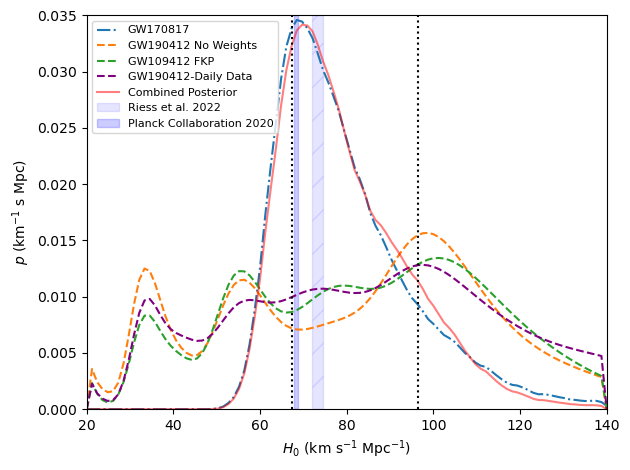

In [26]:
#Plot final posterior

H0_maxlike, H0_err_p , H0_err_m  = pos.cl_range(X_plot,posterior_comb2,cl=cl)
H0_16=pos.percentile(0.16, posterior_comb2, H0_array_out)
H0_84=pos.percentile(0.84, posterior_comb2, H0_array_out)
H0_median=pos.percentile(0.50,posterior_comb2,H0_array_out)
print(H0_maxlike)
print(H0_err_p)
print(H0_err_m)
print(H0_16)
print(H0_84)

plt.plot(X_plot,posterior_em,'-.',label='GW170817')
#plt.plot(H0_array_out, posterior_all,'--',c='k',alpha=0.5,label='GW190412 All Weights')
plt.plot(H0_array_out,posterior,'--',label='GW190412 No Weights')
plt.plot(H0_array_out,posterior1,'--',label='GW109412 FKP')
#plt.plot(H0_array_out,posterior2,'--',label='GW190412 FKP+SYS')
plt.plot(H0_array_out,dailyposterior,'--',c='purple',label='GW190412-Daily Data')
#plt.plot(H0_array_out, posterior_comb,c='green', alpha=0.5,label='GW170817+GW190412')
plt.plot(X_plot,posterior_comb2,c='red',alpha=0.5, label='Combined Posterior')
plt.legend()
#plt.axvline(x=H0_maxlike,color='k')
plt.axvline(x=H0_16,color='k',linestyle='dotted')
plt.axvline(x=H0_84,color='k',linestyle='dotted')


#plt.plot(X_plot,posterior_comb,'-.', c='green',alpha=0.5, label='Combined')

#Graph settings
plt.xlabel(r'$H_0~{\rm (km ~s^{-1}~Mpc^{-1})}$')
plt.xlim(20,140)
plt.ylim(0,0.035)
plt.ylabel(r'$p ~{\rm (km^{-1} ~s~Mpc)}$')
plt.fill_between(np.array([73.2-1.3,73.2 +1.3]),np.array([0.,0.0]),np.array([0.035,0.035]), color='#0000ff',alpha=0.1,hatch="/",label='Riess et al. 2022',zorder=0)
plt.fill_between(np.array([68.82,67.90]),np.array([0.,0.0]),np.array([0.035,0.035]), color='#0000ff',alpha=0.2,label='Planck Collaboration 2020',zorder=0)
plt.tight_layout()
plt.legend(loc='upper left',prop={"size":8})


#Write final results to txt file
outfile = open('H0_summary_final.txt','w')
outfile.write('# H0_maxlike H0_errp H0_errm H0_median \n')
outfile.write(' %f %f %f %f\n' % ( H0_maxlike,H0_err_p, H0_err_m, H0_median))
outfile.close()

plt.savefig('posterior_updated.png',dpi=200)

H0_maxlike, H0_err_p , H0_err_m  = pos.cl_range(H0_array_out,dailyposterior,cl=cl)
H0_median=pos.percentile(0.50, dailyposterior, H0_array_out)





In [25]:
from astropy.io import ascii
data=ascii.read("tiles-main.ecsv")
ra_tiles=data['RA']
dec_tiles=data['DEC']
mask_program=(data['PROGRAM']=='BRIGHT')
#print(mask_program)
ra_tiles=ra_tiles[mask_program]
dec_tiles=dec_tiles[mask_program]
#mask_loc=(np.logical_and(ra_tiles<210.9, ra_tiles>215.5) & np.logical_and(dec_tiles<38.5, dec_tiles>33.8))
ra_tiles=ra_tiles.tolist()
dec_tiles=dec_tiles.tolist()

/global/u2/w/wballard/standard-sirens/gw_skymap.py:249: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_697319/3239849821.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/tmp/ipykernel_697319/3239849821.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('GW190412_targets.png')
/global/homes/w/wballard/.conda/envs/standard-sirens/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


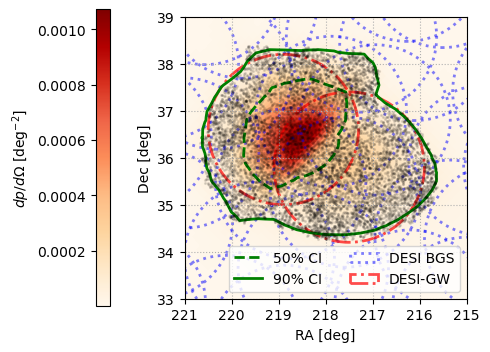

In [14]:
from gw_skymap import plot_cartmap

gwfile='/global/homes/w/wballard/catalogs/GW190412_skymap.fits.gz'
fig=plot_cartmap(gwfile,tile_ra=ra_tiles,tile_dec=dec_tiles,targ_ra=ra_gal,targ_dec=dec_gal,levels=[0.5,0.90])
fig.tight_layout()
fig.savefig('GW190412_targets.png')

(6305,)
(5910,)
[0.         0.         0.         0.00574581 0.01842808 0.01028464
 0.01598956 0.08367047 0.06134706 0.00478647 0.02202057 0.09758091
 0.01763151 0.06293955 0.09450717 0.055359   0.10324035 0.08660119
 0.159887   0.09567502 0.05481375 0.08061585 0.07359998 0.13003361
 0.04475054 0.02500045 0.02821713 0.0491212  0.02752629]


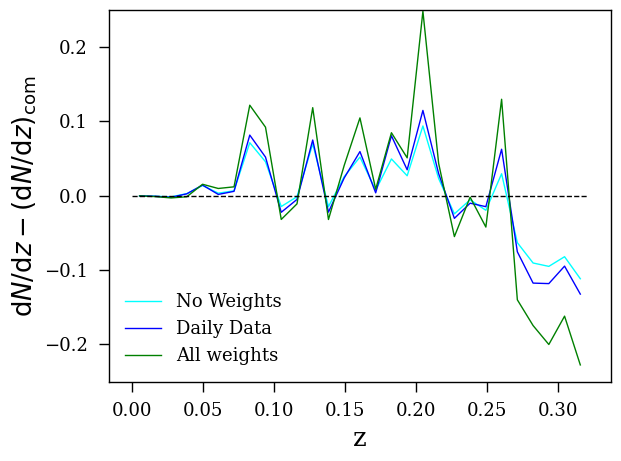

In [19]:
def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':13.0,
                        'text.color':'black',
                        'text.usetex':False,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})

table20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

event='GW190412'
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)


bins=np.linspace(0,z_max,num=30)
zbins = np.zeros(bins.shape[0]-1)
for i in range(bins.shape[0]-1): 
    zbins[i]=(bins[i+1]+bins[i])/2.

#



print(np.shape(z_gal_old))
print(np.shape(weight_gal3))
mean_z,_=np.histogram(z_gal_old,bins=bins,weights=pb_gal_old)
mean_z2,_=np.histogram(z_gal,bins=bins,weights=pb_gal)
mean_z3,_=np.histogram(z_gal_old2,bins=bins,weights=weight_gal3*pb_gal_old2)
print(mean_z)

plt_style()

dV = cosmo.differential_comoving_volume(zbins).value


norm_mean=mean_z.sum()
dV_n=dV/dV.sum()*norm_mean
plt.plot(zbins,mean_z-dV_n,  label='No Weights',color='aqua')

norm_mean=mean_z2.sum()
dV_n=dV/dV.sum()*norm_mean
plt.plot(zbins,mean_z2-dV_n, label='Daily Data',color='blue')

norm_mean=mean_z3.sum()
dV_n=dV/dV.sum()*norm_mean
plt.plot(zbins,mean_z3-dV_n, label='All weights',color='green')
plt.legend()

plt.xlabel('z')
plt.ylabel(r'${\rm d} N/{\rm d}z - ({\rm d}N/{\rm d}z)_{\rm com}$')
plt.plot([0,z_max],[0.,0.], 'k--')
plt.ylim(-0.25,0.25)
plt.tight_layout()
plt.savefig('GW190412-dNdz-weighted_pb.png',dpi=200)

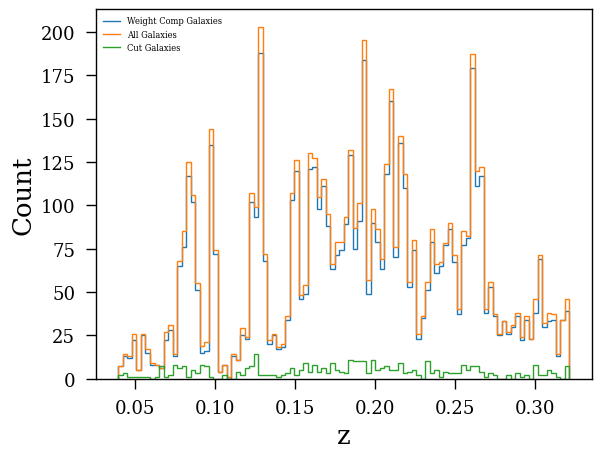

In [20]:
z_comp,bins=np.histogram(z_gal_old2,bins=100)
z_none,_=np.histogram(z_gal_old,bins=100)
z_cut,_=np.histogram(z_gal_cut,bins=100)
plt.stairs(z_comp,bins,label='Weight Comp Galaxies')
plt.stairs(z_none,bins,label='All Galaxies')
plt.stairs(z_cut,bins,label='Cut Galaxies')
plt.xlabel('z')
plt.ylabel('Count')
plt.legend(loc=2,prop={'size':6})